This notebook compares four different data and model configurations on the TDT sentiment data set:


1. Focus sentence only (mBERT)
2. Focus sentence only (FinBERT)
3. Left context + focus sentence (FinBERT)
4. Left context + focus sentence + right context (FinBERT)

In each case, TFBertForSequenceClassification from Huggingface Transformers is used as the model. With the non-contextual data, uncased models are used, while the contextual data configurations use cased FinBERT.

In [9]:
# Set the file paths here
tdt_train_fn = '/content/tdt-sentiment-151020-train-clean.tsv'
tdt_eval_fn = '/content/tdt-sentiment-151020-dev.tsv'
tdt_unannotated_full_train_fn = '/content/tdt-train-texts.tsv'
tdt_unannotated_full_eval_fn = '/content/tdt-dev-texts.tsv'

In [ ]:
!pip install transformers

In [10]:
# Read files and set up noncontextual input

from transformers import BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
from itertools import groupby
import tensorflow as tf

def transpose(l):
  return [list(t) for t in zip(*l)]

def load_fields(fn):
  return transpose([l.rstrip('\n').split('\t') for l in open(fn).readlines()])

train_id, train_texts, train_labels_raw = load_fields(tdt_train_fn)[:3]
eval_id, eval_texts, eval_labels_raw = load_fields(tdt_eval_fn)[:3]

group_train_id, group_train_texts = load_fields(tdt_unannotated_full_train_fn)[:2]
group_eval_id, group_eval_texts = load_fields(tdt_unannotated_full_eval_fn)[:2]

label_encoder = LabelEncoder()
label_encoder.fit(train_labels_raw)
train_labels = label_encoder.transform(train_labels_raw).tolist()
eval_labels = label_encoder.transform(eval_labels_raw).tolist()
num_labels = len(label_encoder.classes_)

model_name_ml = "bert-base-multilingual-uncased"
model_name_nc = "TurkuNLP/bert-base-finnish-uncased-v1"
model_name_c = "TurkuNLP/bert-base-finnish-cased-v1"

tokenizer_ml = BertTokenizerFast.from_pretrained(model_name_ml)
tokenizer_nc = BertTokenizerFast.from_pretrained(model_name_nc)
tokenizer_c = BertTokenizerFast.from_pretrained(model_name_c)

input_size_nc = 128
input_size_c = 256

train_encodings_ml = tokenizer_ml(train_texts, truncation=True, padding='longest', max_length=input_size_nc)
eval_encodings_ml = tokenizer_ml(eval_texts, truncation=True, padding='longest', max_length=input_size_nc)
train_encodings_nc = tokenizer_nc(train_texts, truncation=True, padding='longest', max_length=input_size_nc)
eval_encodings_nc = tokenizer_nc(eval_texts, truncation=True, padding='longest', max_length=input_size_nc)
train_encodings_c = list(zip([s.split('.', 1)[0] for s in group_train_id], tokenizer_c(group_train_texts, add_special_tokens=False)['input_ids']))
eval_encodings_c = list(zip([s.split('.', 1)[0] for s in group_eval_id], tokenizer_c(group_eval_texts, add_special_tokens=False)['input_ids']))

t_ml = [tf.constant(train_encodings_ml.data[s]) for s in ['input_ids', 'attention_mask', 'token_type_ids']]
e_ml = [tf.constant(eval_encodings_ml.data[s]) for s in ['input_ids', 'attention_mask', 'token_type_ids']]

t_nc = [tf.constant(train_encodings_nc.data[s]) for s in ['input_ids', 'attention_mask', 'token_type_ids']]
e_nc = [tf.constant(eval_encodings_nc.data[s]) for s in ['input_ids', 'attention_mask', 'token_type_ids']]

In [11]:
# Set up contextual input

def add_left_sep_context(ids, labels, encodings, input_size, tokenizer):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    sentence_size = min(len(group[i]), input_size - 3)
    context_size = max(input_size - sentence_size - 3, 0)
    prev_context = prev_context[len(prev_context)-context_size:]
    input = [tokenizer.cls_token_id] + prev_context + [tokenizer.sep_token_id] + group[i][:sentence_size] + [tokenizer.sep_token_id]
    mask = [0] + [0]*len(prev_context) + [0] + [1]*sentence_size + [1]
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

def add_full_sep_context(ids, labels, encodings, input_size, tokenizer):
  group_encodings = dict([(k, [v for _, v in list(g)]) for k, g in groupby(encodings, lambda x: x[0])])
  contextualized = []
  for id, label in zip(ids, labels):
    group_id, n = id.split('.', 1)
    i = int(n)-1
    group = group_encodings[group_id]
    prev_context = [e for l in group[:i] for e in l]
    fol_context = [e for l in group[i+1:] for e in l]
    sentence_size = min(len(group[i]), input_size - 3)
    context_size = max(input_size - sentence_size - 3, 0)
    prev_context = prev_context[len(prev_context)-max(context_size-len(fol_context), context_size//2):]
    fol_context = fol_context[:context_size-len(prev_context)]
    input = [tokenizer.cls_token_id] + prev_context + [tokenizer.sep_token_id] + group[i][:sentence_size] + [tokenizer.sep_token_id] + fol_context
    mask = [0] + [0]*len(prev_context) + [0] + [1]*sentence_size + [1] + [0]*len(fol_context)
    contextualized.append((input, mask))
  
  return tuple(list(t) for t in zip(*contextualized))

def pad(l, size):
  return [s + [0]*(size - len(s)) for s in l]

left_sep_train_context = add_left_sep_context(train_id, train_labels, train_encodings_c, input_size_c, tokenizer_c)
left_sep_eval_context = add_left_sep_context(eval_id, eval_labels, eval_encodings_c, input_size_c, tokenizer_c)

left_sep_train_attention_mask = pad([[1]*len(s) for s in left_sep_train_context[0]], input_size_c)
left_sep_train_input = pad(left_sep_train_context[0], input_size_c)
left_sep_train_mask = pad(left_sep_train_context[1], input_size_c)
left_sep_eval_attention_mask = pad([[1]*len(s) for s in left_sep_eval_context[0]], input_size_c)
left_sep_eval_input = pad(left_sep_eval_context[0], input_size_c)
left_sep_eval_mask = pad(left_sep_eval_context[1], input_size_c)

full_sep_train_context = add_full_sep_context(train_id, train_labels, train_encodings_c, input_size_c, tokenizer_c)
full_sep_eval_context = add_full_sep_context(eval_id, eval_labels, eval_encodings_c, input_size_c, tokenizer_c)

full_sep_train_attention_mask = pad([[1]*len(s) for s in full_sep_train_context[0]], input_size_c)
full_sep_train_input = pad(full_sep_train_context[0], input_size_c)
full_sep_train_mask = pad(full_sep_train_context[1], input_size_c)
full_sep_eval_attention_mask = pad([[1]*len(s) for s in full_sep_eval_context[0]], input_size_c)
full_sep_eval_input = pad(full_sep_eval_context[0], input_size_c)
full_sep_eval_mask = pad(full_sep_eval_context[1], input_size_c)

t_left_sep = [tf.constant(left_sep_train_input),
              tf.constant(left_sep_train_attention_mask),
              tf.constant(left_sep_train_mask)]

e_left_sep = [tf.constant(left_sep_eval_input),
              tf.constant(left_sep_eval_attention_mask),
              tf.constant(left_sep_eval_mask)]

t_full_sep = [tf.constant(full_sep_train_input),
              tf.constant(full_sep_train_attention_mask),
              tf.constant(full_sep_train_mask)]

e_full_sep = [tf.constant(full_sep_eval_input),
              tf.constant(full_sep_eval_attention_mask),
              tf.constant(full_sep_eval_mask)]

In [12]:
# Set up training

from transformers import TFBertForSequenceClassification, optimization_tf

class ReturnBestEarlyStopping(tf.keras.callbacks.EarlyStopping):
  def __init__(self, **kwargs):
    super(ReturnBestEarlyStopping, self).__init__(**kwargs)
  
  def on_train_end(self, logs=None):
    if self.restore_best_weights:
      self.model.set_weights(self.best_weights)

init_lr_ml = 2e-5
epochs_ml = 5
init_lr_nc = 2e-5
epochs_nc = 3
init_lr_c = 2e-5
epochs_c = 3
batch_size_train = 16

def train(model_name, t, train_labels, eval, num_labels, init_lr, epochs, batch_size_train):
  size_train = len(train_labels)
  steps_per_epoch = int(size_train/batch_size_train)
  steps_train = steps_per_epoch*epochs
  steps_warmup = int(epochs * size_train * 0.1 / batch_size_train)

  model = TFBertForSequenceClassification.from_pretrained(model_name,
                                                          num_labels=num_labels)
  optimizer, _ = optimization_tf.create_optimizer(init_lr=init_lr,
                                                  num_train_steps=steps_train,
                                                  num_warmup_steps=steps_warmup,
                                                  weight_decay_rate=0.01)
  model.compile(optimizer=optimizer,
                loss=model.compute_loss,
                metrics=['sparse_categorical_accuracy'])
  model.fit(t,
            train_labels,
            validation_data=eval,
            batch_size=batch_size_train,
            epochs=epochs,
            callbacks=[ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4, restore_best_weights=True)])
  return model

In [13]:
# Set up evaluation

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def train_evaluate(runs, model_name, train_x, train_y, eval_x, eval_y, num_labels, init_lr, epochs, batch_size_train, run_count):
  for i in range(run_count):
    bert = train(model_name, train_x, train_y, (eval_x, eval_y), num_labels, init_lr, epochs, batch_size_train)
    runs.append(bert.predict(eval_x)[0])

def format_floats(l):
  return ', '.join(f'{x:.4f}' for x in l)

def print_results(runs, eval_labels):
  accuracy = [accuracy_score(eval_labels, p.argmax(-1)) for p in runs]
  weighted_f1 = [f1_score(eval_labels, p.argmax(-1), average='weighted') for p in runs]
  print(f"Accuracy: {format_floats(accuracy)}")
  print(f"Weighted F-score: {format_floats(weighted_f1)}")
  print(f'Average accuracy: {np.mean(accuracy):.4f}, stdev: {np.std(accuracy):.4f}')
  print(f'Average weighted F-score: {np.mean(weighted_f1):.4f}, stdev: {np.std(weighted_f1):.4f}')
  max_i = accuracy.index(max(accuracy))
  max_p = runs[max_i].argmax(-1)
  ConfusionMatrixDisplay(confusion_matrix(eval_labels, max_p), label_encoder.classes_).plot()
  print(classification_report(eval_labels, max_p, target_names=label_encoder.classes_, digits=4))

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.9204 - sparse_categorical_accuracy: 0.7129

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 229s 306ms/step - loss: 0.9202 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.6778 - val_sparse_categorical_accuracy: 0.7384
Epoch 2/5
686/686 [==============================] - 206s 301ms/step - loss: 0.5590 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.6174 - val_sparse_categorical_accuracy: 0.7765
Epoch 3/5
686/686 [==============================] - 206s 300ms/step - loss: 0.3625 - sparse_categorical_accuracy: 0.8724 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.7739
Epoch 4/5
686/686 [==============================] - 206s 301ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9199 - val_loss: 0.7723 - val_sparse_categorical_accuracy: 0.7917
Epoch 5/5
686/686 [==============================] - 206s 300ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.9596 - val_loss: 0.8314 - val_sparse_categorical_accuracy: 0.7807


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mo

Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.9943 - sparse_categorical_accuracy: 0.6113

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 227s 305ms/step - loss: 0.9941 - sparse_categorical_accuracy: 0.6115 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.7290
Epoch 2/5
686/686 [==============================] - 205s 298ms/step - loss: 0.6105 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.7604
Epoch 3/5
686/686 [==============================] - 206s 300ms/step - loss: 0.4203 - sparse_categorical_accuracy: 0.8398 - val_loss: 0.7022 - val_sparse_categorical_accuracy: 0.7790
Epoch 4/5
686/686 [==============================] - 206s 300ms/step - loss: 0.2769 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.7944 - val_sparse_categorical_accuracy: 0.7765
Epoch 5/5
686/686 [==============================] - 206s 300ms/step - loss: 0.1810 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.8860 - val_sparse_categorical_accuracy: 0.7849


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mo

Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.9267 - sparse_categorical_accuracy: 0.7116

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 228s 305ms/step - loss: 0.9265 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.6341 - val_sparse_categorical_accuracy: 0.7671
Epoch 2/5
686/686 [==============================] - 206s 300ms/step - loss: 0.5542 - sparse_categorical_accuracy: 0.7918 - val_loss: 0.5976 - val_sparse_categorical_accuracy: 0.7832
Epoch 3/5
686/686 [==============================] - 206s 300ms/step - loss: 0.3659 - sparse_categorical_accuracy: 0.8681 - val_loss: 0.6272 - val_sparse_categorical_accuracy: 0.7798
Epoch 4/5
686/686 [==============================] - 206s 301ms/step - loss: 0.2076 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.7844 - val_sparse_categorical_accuracy: 0.7892
Epoch 5/5
686/686 [==============================] - 206s 300ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.9591 - val_loss: 0.8546 - val_sparse_categorical_accuracy: 0.7782


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mo

Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.9315 - sparse_categorical_accuracy: 0.6699

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 227s 305ms/step - loss: 0.9313 - sparse_categorical_accuracy: 0.6700 - val_loss: 0.6438 - val_sparse_categorical_accuracy: 0.7333
Epoch 2/5
686/686 [==============================] - 206s 301ms/step - loss: 0.5439 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.6046 - val_sparse_categorical_accuracy: 0.7959
Epoch 3/5
686/686 [==============================] - 206s 300ms/step - loss: 0.3505 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.6089 - val_sparse_categorical_accuracy: 0.8002
Epoch 4/5
686/686 [==============================] - 206s 300ms/step - loss: 0.2157 - sparse_categorical_accuracy: 0.9297 - val_loss: 0.7106 - val_sparse_categorical_accuracy: 0.7875
Epoch 5/5
686/686 [==============================] - 205s 299ms/step - loss: 0.1400 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.8006 - val_sparse_categorical_accuracy: 0.7993


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mo

Epoch 1/5


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.9339 - sparse_categorical_accuracy: 0.5994

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 226s 304ms/step - loss: 0.9337 - sparse_categorical_accuracy: 0.5996 - val_loss: 0.6174 - val_sparse_categorical_accuracy: 0.7646
Epoch 2/5
686/686 [==============================] - 205s 300ms/step - loss: 0.5458 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.6184 - val_sparse_categorical_accuracy: 0.7858
Epoch 3/5
686/686 [==============================] - 206s 301ms/step - loss: 0.3532 - sparse_categorical_accuracy: 0.8733 - val_loss: 0.6684 - val_sparse_categorical_accuracy: 0.7883
Epoch 4/5
686/686 [==============================] - 206s 300ms/step - loss: 0.2078 - sparse_categorical_accuracy: 0.9308 - val_loss: 0.7802 - val_sparse_categorical_accuracy: 0.7900
Epoch 5/5
686/686 [==============================] - 205s 299ms/step - loss: 0.1222 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.8532 - val_sparse_categorical_accuracy: 0.7934


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: bert-base-multilingual-uncased, initial learning rate = 2e-05, input size = 128, batch size = 16, epochs = 5
Accuracy: 0.7917, 0.7849, 0.7892, 0.8002, 0.7934
Weighted F-score: 0.7752, 0.7681, 0.7702, 0.7897, 0.7789
Average accuracy: 0.7919, stdev: 0.0050
Average weighted F-score: 0.7764, stdev: 0.0076
              precision    recall  f1-score   support

    negative     0.5464    0.4141    0.4711       128
     neutral     0.8649    0.9281    0.8954       862
       other     0.5309    0.5059    0.5181        85
    positive     0.6282    0.4623    0.5326       106

    accuracy                         0.8002      1181
   macro avg     0.6426    0.5776    0.6043      1181
weighted avg     0.7851    0.8002    0.7897      1181



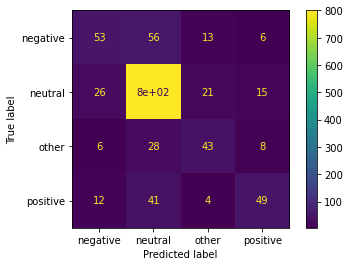

In [ ]:
# Evaluate noncontextual data with mBERT

runs_multilingual = []
train_evaluate(runs_multilingual, model_name_ml, t_ml, tf.constant(train_labels), e_ml, tf.constant(eval_labels), num_labels, init_lr_ml, epochs_ml, batch_size_train, 5)
print(f"Model: {model_name_ml}, initial learning rate = {init_lr_ml}, input size = {input_size_nc}, batch size = {batch_size_train}, epochs = {epochs_ml}")
print_results(runs_multilingual, eval_labels)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7735 - sparse_categorical_accuracy: 0.6957

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 221s 293ms/step - loss: 0.7732 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.3642 - val_sparse_categorical_accuracy: 0.8654
Epoch 2/3
686/686 [==============================] - 198s 289ms/step - loss: 0.2551 - sparse_categorical_accuracy: 0.9130 - val_loss: 0.3222 - val_sparse_categorical_accuracy: 0.8831
Epoch 3/3
686/686 [==============================] - 198s 289ms/step - loss: 0.1207 - sparse_categorical_accuracy: 0.9633 - val_loss: 0.3715 - val_sparse_categorical_accuracy: 0.8840


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in g

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7952 - sparse_categorical_accuracy: 0.6708

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 216s 291ms/step - loss: 0.7949 - sparse_categorical_accuracy: 0.6710 - val_loss: 0.3833 - val_sparse_categorical_accuracy: 0.8662
Epoch 2/3
686/686 [==============================] - 196s 285ms/step - loss: 0.2392 - sparse_categorical_accuracy: 0.9209 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/3
686/686 [==============================] - 196s 285ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.3865 - val_sparse_categorical_accuracy: 0.8798


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in g

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7844 - sparse_categorical_accuracy: 0.6983

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 216s 290ms/step - loss: 0.7841 - sparse_categorical_accuracy: 0.6984 - val_loss: 0.3562 - val_sparse_categorical_accuracy: 0.8679
Epoch 2/3
686/686 [==============================] - 195s 285ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.8865
Epoch 3/3
686/686 [==============================] - 195s 285ms/step - loss: 0.1132 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.3774 - val_sparse_categorical_accuracy: 0.8874


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in g

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7966 - sparse_categorical_accuracy: 0.6819

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 216s 291ms/step - loss: 0.7962 - sparse_categorical_accuracy: 0.6821 - val_loss: 0.3518 - val_sparse_categorical_accuracy: 0.8772
Epoch 2/3
686/686 [==============================] - 195s 285ms/step - loss: 0.2538 - sparse_categorical_accuracy: 0.9164 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.8823
Epoch 3/3
686/686 [==============================] - 195s 284ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.3853 - val_sparse_categorical_accuracy: 0.8738


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in g

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7301 - sparse_categorical_accuracy: 0.7557

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 215s 290ms/step - loss: 0.7299 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.3427 - val_sparse_categorical_accuracy: 0.8747
Epoch 2/3
686/686 [==============================] - 195s 284ms/step - loss: 0.2399 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.3268 - val_sparse_categorical_accuracy: 0.8764
Epoch 3/3
686/686 [==============================] - 195s 284ms/step - loss: 0.0971 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8798


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in g

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7157 - sparse_categorical_accuracy: 0.7826

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 215s 290ms/step - loss: 0.7154 - sparse_categorical_accuracy: 0.7826 - val_loss: 0.3489 - val_sparse_categorical_accuracy: 0.8747
Epoch 2/3
686/686 [==============================] - 195s 284ms/step - loss: 0.2583 - sparse_categorical_accuracy: 0.9139 - val_loss: 0.3528 - val_sparse_categorical_accuracy: 0.8755
Epoch 3/3
686/686 [==============================] - 195s 284ms/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.3741 - val_sparse_categorical_accuracy: 0.8831


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in g

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7635 - sparse_categorical_accuracy: 0.7129

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 215s 290ms/step - loss: 0.7632 - sparse_categorical_accuracy: 0.7130 - val_loss: 0.3422 - val_sparse_categorical_accuracy: 0.8831
Epoch 2/3
686/686 [==============================] - 195s 284ms/step - loss: 0.2565 - sparse_categorical_accuracy: 0.9140 - val_loss: 0.3280 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/3
686/686 [==============================] - 195s 284ms/step - loss: 0.1119 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.3558 - val_sparse_categorical_accuracy: 0.8815


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: TurkuNLP/bert-base-finnish-uncased-v1, initial learning rate = 2e-05, input size = 128, batch size = 16, epochs = 3
Accuracy: 0.8840, 0.8798, 0.8874, 0.8823, 0.8798, 0.8831, 0.8831
Weighted F-score: 0.8801, 0.8752, 0.8833, 0.8783, 0.8759, 0.8803, 0.8798
Average accuracy: 0.8828, stdev: 0.0024
Average weighted F-score: 0.8790, stdev: 0.0026
              precision    recall  f1-score   support

    negative     0.8280    0.6016    0.6968       128
     neutral     0.9181    0.9629    0.9400       862
       other     0.6627    0.6471    0.6548        85
    positive     0.8515    0.8113    0.8309       106

    accuracy                         0.8874      1181
   macro avg     0.8151    0.7557    0.7806      1181
weighted avg     0.8840    0.8874    0.8833      1181



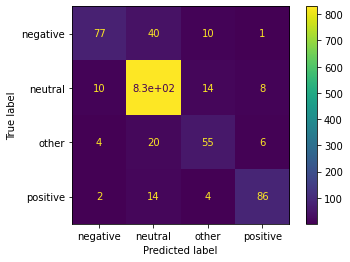

In [ ]:
# Evaluate noncontextual data with FinBERT

runs_no_context = []
train_evaluate(runs_no_context, model_name_nc, t_nc, tf.constant(train_labels), e_nc, tf.constant(eval_labels), num_labels, init_lr_nc, epochs_nc, batch_size_train, 7)
print(f"Model: {model_name_nc}, initial learning rate = {init_lr_nc}, input size = {input_size_nc}, batch size = {batch_size_train}, epochs = {epochs_nc}")
print_results(runs_no_context, eval_labels)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7851 - sparse_categorical_accuracy: 0.6960

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 389s 540ms/step - loss: 0.7848 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.3469 - val_sparse_categorical_accuracy: 0.8747
Epoch 2/3
686/686 [==============================] - 367s 535ms/step - loss: 0.2425 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.3189 - val_sparse_categorical_accuracy: 0.8848
Epoch 3/3
686/686 [==============================] - 366s 533ms/step - loss: 0.0929 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.3649 - val_sparse_categorical_accuracy: 0.8899


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in gra

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7287 - sparse_categorical_accuracy: 0.7706

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 385s 538ms/step - loss: 0.7284 - sparse_categorical_accuracy: 0.7707 - val_loss: 0.3508 - val_sparse_categorical_accuracy: 0.8721
Epoch 2/3
686/686 [==============================] - 367s 535ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.9206 - val_loss: 0.3182 - val_sparse_categorical_accuracy: 0.8831
Epoch 3/3
686/686 [==============================] - 367s 535ms/step - loss: 0.0871 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.3495 - val_sparse_categorical_accuracy: 0.8908


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in gra

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7853 - sparse_categorical_accuracy: 0.6942

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 386s 538ms/step - loss: 0.7849 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.3215 - val_sparse_categorical_accuracy: 0.8747
Epoch 2/3
686/686 [==============================] - 366s 534ms/step - loss: 0.2397 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.3115 - val_sparse_categorical_accuracy: 0.8789
Epoch 3/3
686/686 [==============================] - 367s 535ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.3275 - val_sparse_categorical_accuracy: 0.8831


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in gra

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7650 - sparse_categorical_accuracy: 0.7245

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 389s 541ms/step - loss: 0.7647 - sparse_categorical_accuracy: 0.7246 - val_loss: 0.3155 - val_sparse_categorical_accuracy: 0.8874
Epoch 2/3
686/686 [==============================] - 369s 538ms/step - loss: 0.2351 - sparse_categorical_accuracy: 0.9224 - val_loss: 0.3203 - val_sparse_categorical_accuracy: 0.8764
Epoch 3/3
686/686 [==============================] - 370s 539ms/step - loss: 0.0988 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.3545 - val_sparse_categorical_accuracy: 0.8823


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in gra

Epoch 1/3


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - ETA: 0s - loss: 0.7406 - sparse_categorical_accuracy: 0.7644

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


686/686 [==============================] - 391s 543ms/step - loss: 0.7403 - sparse_categorical_accuracy: 0.7645 - val_loss: 0.3121 - val_sparse_categorical_accuracy: 0.8840
Epoch 2/3
686/686 [==============================] - 369s 538ms/step - loss: 0.2447 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.3198 - val_sparse_categorical_accuracy: 0.8806
Epoch 3/3
686/686 [==============================] - 369s 539ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.3585 - val_sparse_categorical_accuracy: 0.8781


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 3
Accuracy: 0.8899, 0.8908, 0.8831, 0.8874, 0.8840
Weighted F-score: 0.8863, 0.8881, 0.8803, 0.8852, 0.8802
Average accuracy: 0.8870, stdev: 0.0031
Average weighted F-score: 0.8840, stdev: 0.0032
              precision    recall  f1-score   support

    negative     0.8211    0.6094    0.6996       128
     neutral     0.9262    0.9606    0.9431       862
       other     0.6421    0.7176    0.6778        85
    positive     0.8763    0.8019    0.8374       106

    accuracy                         0.8908      1181
   macro avg     0.8164    0.7724    0.7895      1181
weighted avg     0.8899    0.8908    0.8881      1181



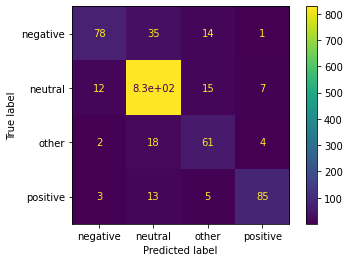

In [9]:
# Evaluate data with left context only

runs_left_context = []
train_evaluate(runs_left_context, model_name_c, t_left_sep, tf.constant(train_labels), e_left_sep, tf.constant(eval_labels), num_labels, init_lr_c, epochs_c, batch_size_train, 5)
print(f"Model: {model_name_c}, initial learning rate = {init_lr_c}, input size = {input_size_c}, batch size = {batch_size_train}, epochs = {epochs_c}")
print_results(runs_left_context, eval_labels)

Model: TurkuNLP/bert-base-finnish-cased-v1, initial learning rate = 2e-05, input size = 256, batch size = 16, epochs = 3
Accuracy: 0.8908, 0.8959, 0.8908, 0.8848, 0.8916
Weighted F-score: 0.8865, 0.8926, 0.8865, 0.8833, 0.8883
Average accuracy: 0.8908, stdev: 0.0035
Average weighted F-score: 0.8874, stdev: 0.0030
              precision    recall  f1-score   support

    negative     0.8300    0.6484    0.7281       128
     neutral     0.9226    0.9675    0.9445       862
       other     0.6977    0.7059    0.7018        85
    positive     0.8901    0.7642    0.8223       106

    accuracy                         0.8959      1181
   macro avg     0.8351    0.7715    0.7992      1181
weighted avg     0.8934    0.8959    0.8926      1181



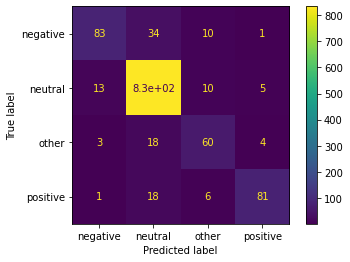

In [16]:
# Evaluate data with both left and right context

runs_full_context = []
train_evaluate(runs_full_context, model_name_c, t_full_sep, tf.constant(train_labels), e_full_sep, tf.constant(eval_labels), num_labels, init_lr_c, epochs_c, batch_size_train, 5)
print(f"Model: {model_name_c}, initial learning rate = {init_lr_c}, input size = {input_size_c}, batch size = {batch_size_train}, epochs = {epochs_c}")
print_results(runs_full_context, eval_labels)